# Packages Loading 

In [26]:
# Standard library imports
import pandas as pd
import re
from collections import Counter

# Natural Language Processing (NLP) libraries
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import cmudict

# Text processing and analysis libraries
from textblob import TextBlob

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import randint

# Data loading and screening

In [6]:
# Load the raw data
reviews_raw = pd.read_csv('raw_data/Reviews.csv')

In [9]:
#Check if HelpfulnessNumerator is bigger then HelpfulnessDenominator
reviews_raw = reviews_raw[reviews_raw['HelpfulnessNumerator'] <= reviews_raw['HelpfulnessDenominator']]

# Feature Creation

In [15]:
#Calculate the Helpfulness ratio and focus on the reviews that are not extreme
reviews_raw['Helpfulness_ratio'] = reviews_raw['HelpfulnessNumerator'] / reviews_raw['HelpfulnessDenominator']
reviews_raw = reviews_raw[(reviews_raw['Helpfulness_ratio'] < 1) & (reviews_raw['Helpfulness_ratio'] > 0)]

In [18]:
#Calculate text length
reviews_raw['len_text'] = reviews_raw['Text'].apply(lambda x: len(x.split()))

/var/folders/4q/jy5tm04141s0j174dgw0xcsm0000gn/T/ipykernel_25578/3396694130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_raw['len_text'] = reviews_raw['Text'].apply(lambda x: len(x.split()))


In [ ]:
#Quick Sentiment Analysis
reviews_raw['sentiment'] = reviews_raw['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
# Average Sentence Length
reviews_raw['avg_sent_length'] = reviews_raw['Text'].apply(lambda x: len(x.split()) / len(TextBlob(x).sentences))

# Average Word Length
reviews_raw['avg_word_length'] = reviews_raw['Text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

## Dealing with sentence complexity with gunning fog method

In [25]:
# Downloading the cmudict corpus for syllable estimation
nltk.download('punkt')
nltk.download('cmudict')

# Preparing the CMU Pronouncing Dictionary
d = cmudict.dict()

def nsyl(word):
    # Return syllable count for a word, using the CMU Pronouncing Dictionary
    # If the word is not found in the dictionary, estimate the syllable count
    if word.lower() in d:
        return max([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    else:
        return syllable_count(word)

def syllable_count(word):
    # Manually estimate syllable count if word is not in the CMU dict
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count += 1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
        count += 1
    if count == 0:
        count += 1
    return count

def gunning_fog(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    complex_words_count = sum([1 for word in words if nsyl(word) > 2])

    try:
        avg_sentence_length = len(words) / len(sentences)
        percent_complex_words = (complex_words_count / len(words)) * 100
        fog_index = 0.4 * (avg_sentence_length + percent_complex_words)
    except ZeroDivisionError:  # Handles the edge case of a division by zero
        return np.nan

    return fog_index


[nltk_data] Downloading package punkt to /Users/michele/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cmudict to /Users/michele/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


6.466666666666666

In [28]:
reviews_raw['text_complexity_gf'] = reviews_raw['Text'].apply(lambda x: gunning_fog(x))

/var/folders/4q/jy5tm04141s0j174dgw0xcsm0000gn/T/ipykernel_25578/2651022696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_raw['text_complexity_gf'] = reviews_raw['Text'].apply(lambda x: gunning_fog(x))


## Dealing with feature correlation

In [36]:
# correlation matrix
reviews_raw[['Helpfulness_ratio', 'len_text', 'text_complexity_gf', 'sentiment', 'avg_sent_length', 'avg_word_length']].corr()

,Helpfulness_ratio,len_text,text_complexity_gf,sentiment,avg_sent_length,avg_word_length
Helpfulness_ratio,1.000000,0.143820,0.043481,0.119589,0.026336,0.047339
len_text,0.143820,1.000000,0.295066,-0.090949,0.292807,0.092654
text_complexity_gf,0.043481,0.295066,1.000000,-0.069592,0.946039,0.319977
sentiment,0.119589,-0.090949,-0.069592,1.000000,-0.071879,-0.027924
avg_sent_length,0.026336,0.292807,0.946039,-0.071879,1.000000,0.105208
avg_word_length,0.047339,0.092654,0.319977,-0.027924,0.105208,1.000000


In [40]:
reviews_raw.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Helpfulness_ratio', 'len_text', 'text_complexity_gf', 'sentiment',
       'avg_sent_length', 'avg_word_length'],
      dtype='object')

In [37]:
reviews = reviews_raw[['Helpfulness_ratio', 'len_text', 'text_complexity_gf', 'sentiment', 'avg_word_length', 'Text', 'Score']]

# Data Preprocessing

In [46]:
# Assuming 'reviews' is your DataFrame and 'Helpfulness_ratio' is the target variable
X = reviews.drop(['Helpfulness_ratio'], axis=1)  # Keep 'Text' for NLP processing
y = reviews['Helpfulness_ratio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate the 'Text' column for special processing
X_train_text = X_train['Text']
X_test_text = X_test['Text']

# Process other features excluding 'Text'
X_train_features = X_train.drop(['Text'], axis=1)
X_test_features = X_test.drop(['Text'], axis=1)


In [47]:
scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train_features)

# Transform the test data with the same scaler
X_test_scaled = scaler.transform(X_test_features)


In [48]:

vectorizer = TfidfVectorizer(max_features=1000)  # Limiting to the top 1000 features

# Fit and transform on training data
X_train_text_tfidf = vectorizer.fit_transform(X_train_text)

# Transform the test data
X_test_text_tfidf = vectorizer.transform(X_test_text)


In [49]:

# Combine the numerical and text features
X_train_final = hstack([X_train_scaled, X_train_text_tfidf])
X_test_final = hstack([X_test_scaled, X_test_text_tfidf])


In [52]:
# Binning Helpfulness_ratio for classification: assuming the median as a threshold for simplicity
median_ratio = y_train.median()
y_train_bin = (y_train > median_ratio).astype(int)
y_test_bin = (y_test > median_ratio).astype(int)


# Chose the model with baseline calculations

In [53]:

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X_train_final, y_train_bin)

# Predict on the test data
y_pred = log_reg.predict(X_test_final)

# Evaluate the model
accuracy = accuracy_score(y_test_bin, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test_bin, y_pred))


Accuracy: 0.6216797835710772
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      8319
           1       0.62      0.59      0.60      7945

    accuracy                           0.62     16264
   macro avg       0.62      0.62      0.62     16264
weighted avg       0.62      0.62      0.62     16264



In [54]:

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train_final, y_train_bin)

# Predict on the test data
y_pred_rf = rf_classifier.predict(X_test_final)

# Evaluate the model
accuracy_rf = accuracy_score(y_test_bin, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print(classification_report(y_test_bin, y_pred_rf))


Random Forest Accuracy: 0.7434825381210034
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      8319
           1       0.75      0.71      0.73      7945

    accuracy                           0.74     16264
   macro avg       0.74      0.74      0.74     16264
weighted avg       0.74      0.74      0.74     16264



In [56]:

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the model on the training data
xgb_classifier.fit(X_train_final, y_train_bin)

# Predict on the test data
y_pred_xgb = xgb_classifier.predict(X_test_final)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test_bin, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print(classification_report(y_test_bin, y_pred_xgb))

XGBoost Accuracy: 0.6869158878504673
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      8319
           1       0.69      0.64      0.67      7945

    accuracy                           0.69     16264
   macro avg       0.69      0.69      0.69     16264
weighted avg       0.69      0.69      0.69     16264



The best model seems to be the random forest model. We cross validate this model to have an estimation of the accuracy. 

In [59]:

# Perform cross-validation on the training data
cv_scores = cross_val_score(rf_classifier, X_train_final, y_train_bin, cv=5, n_jobs=-1)  # 5-fold cross-validation

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-Validation Scores: [0.73760664 0.73791407 0.73991238 0.72882398 0.73466564]
Mean CV Accuracy: 0.735784543688008


# Parameter tuning

In [60]:
# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_final, y_train_bin)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 7.0min
[CV] END ma

/Users/michele/.pyenv/versions/3.10.6/envs/amazon_reviews/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 7.8min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 7.8min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 9.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 9.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 5.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_esti

In [61]:


# Define the grid of hyperparameters based on the best parameters from grid search
param_dist = {
    'n_estimators': randint(200, 400),
    'max_depth': [None] + list(randint(5, 30).rvs(10)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=100,
                                   cv=5, scoring='accuracy', random_state=42, n_jobs=-1, verbose=2)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train_final, y_train_bin)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=214; total time=  10.2s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=214; total time=  10.4s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=214; total time=  10.5s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=214; total time=  10.7s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=214; total time=  10.9s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=274; total time=  12.6s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=274; total time=  13.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=274; total time=  13.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=274; total time=  12.9s
[CV] END max_depth=5, min_samples_lea

/Users/michele/.pyenv/versions/3.10.6/envs/amazon_reviews/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=23, min_samples_leaf=4, min_samples_split=8, n_estimators=251; total time= 2.2min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=7, n_estimators=241; total time=  10.4s
[CV] END max_depth=23, min_samples_leaf=4, min_samples_split=8, n_estimators=251; total time= 2.2min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=7, n_estimators=241; total time=  13.6s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=7, n_estimators=241; total time=  13.7s
[CV] END max_depth=21, min_samples_leaf=3, min_samples_split=5, n_estimators=343; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=386; total time=12.4min
[CV] END max_depth=21, min_samples_leaf=3, min_samples_split=5, n_estimators=343; total time= 2.6min
[CV] END max_depth=21, min_samples_leaf=3, min_samples_split=5, n_estimators=343; total time= 2.6min
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=2, n_estimators=259; total time=

In [63]:

# Initialize the Random Forest classifier with best hyperparameters
best_rf_classifier = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=385, random_state=42)

# Perform cross-validation on the training data
cv_scores = cross_val_score(best_rf_classifier, X_train_final, y_train_bin, cv=5, scoring='accuracy', n_jobs=-1)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.74383214 0.7406041  0.7453693  0.74204458 0.74488855]
Mean CV Accuracy: 0.7433477355027033


In [71]:
best_rf_classifier.score(X_test_final, y_test_bin)

0.7482169208066897

# Confusion Matrix 

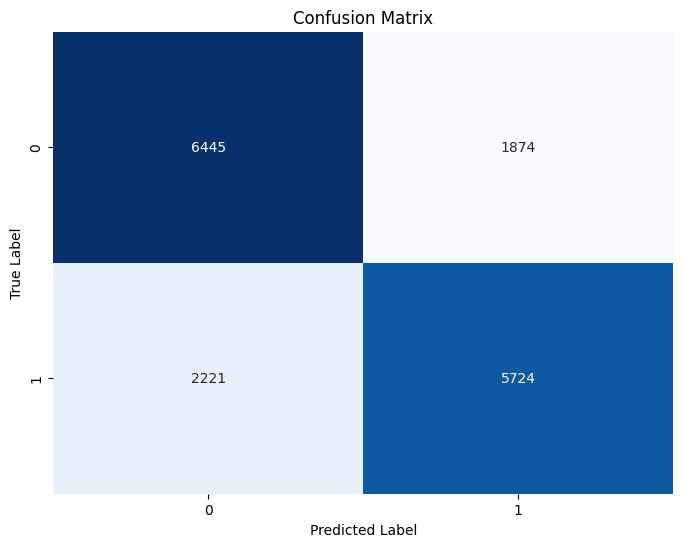

In [74]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

# Predict on the test data
y_pred = best_rf_classifier.predict(X_test_final)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_bin, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix displayed indicates the performance of a classification model on Amazon reviews, with 0 representing 'not so useful' and 1 indicating 'useful' reviews. 

📊 The model has correctly identified 6,445 'not useful' reviews (True Negative) ✅ and 5,724 'useful' reviews (True Positive) ✅. 

However, there are areas where it could improve:
- There were 1,874 instances where 'not useful' reviews were mistakenly labeled as 'useful' (False Positive) ❌.
- In 2,221 cases, 'useful' reviews were wrongly classified as 'not useful' (False Negative) ❌.

This suggests that while the model is quite adept 🎯 at identifying both 'not useful' and 'useful' reviews, it tends to be more conservative, preferring to err on the side of predicting a review as 'useful'. To make the model more reliable, we should look into reducing both False Positives 🚫➡️✅ and False Negatives 🚫⬅️❌.

Overall, while the model shows promise, there's a clear need for further tuning 🛠️ to enhance its precision and ensure users receive the most relevant information.